In [1]:
import pandas as pd
import numpy as np
import dalex as dx
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, accuracy_score


In [2]:
df_modelos = pd.read_csv("data/datosFinales/diferencias_2.csv", sep = ";")
#dropped columns which are 0
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.contains('diferencia_')]
categoricas = pd.read_csv("data/categoricas.csv", sep = ",").squeeze().tolist()
print(len(categoricas))
#remove columns with many NAs
categoricas.remove('tipo_plastia')
categoricas.remove('via_asc_plastia')
print(len(categoricas))

30
28


In [3]:
df_modelos

,id_registro,sexo,edad,peso,talla,imc,neoadyuvancia,localizacion,tipo_histologico,ct,...,sat_oxig_diferencia2_5,temp_corp_diferencia2_5,frec_resp_diferencia2_5,neutrofilos_diferencia2_5,frec_card_diferencia2_5,linfocitos_diferencia2_5,eva_diferencia2_5,plaquetas_diferencia2_5,albumina_diferencia2_5,pcr_diferencia2_5
0,92-1,0.0,61.0,79.0,178.0,24.9,1.0,4.0,1.0,4.0,...,1.0,-0.2,-1.0,-0.528656,NaN,NaN,-2.0,0.206335,-0.9,-14.60
1,92-2,1.0,79.0,95.0,170.0,32.9,0.0,4.0,1.0,2.0,...,-1.0,-0.7,-8.0,0.025972,26.0,NaN,-2.0,0.423668,0.7,-7.70
2,92-3,0.0,74.0,94.0,175.0,30.7,1.0,4.0,NaN,4.0,...,-2.0,0.5,1.0,-0.316932,22.0,NaN,2.0,0.015873,0.2,113.60
3,92-4,0.0,74.0,63.0,168.0,22.3,2.0,3.0,1.0,5.0,...,-13.0,1.5,2.0,NaN,20.0,NaN,4.0,NaN,NaN,NaN
4,92-5,0.0,62.0,57.0,157.0,23.1,2.0,4.0,1.0,4.0,...,-3.0,0.2,0.0,0.961284,7.0,NaN,-2.0,-0.081526,0.8,-165.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,613-30,0.0,72.0,83.0,169.0,29.1,1.0,3.0,1.0,3.0,...,-1.0,-0.3,-1.0,-0.234513,-12.0,-0.495879,-1.0,0.096331,NaN,24.91
724,613-31,1.0,40.0,58.0,160.0,22.7,0.0,5.0,1.0,3.0,...,0.0,-0.2,-2.0,-0.109463,-11.0,-0.743461,-3.0,0.373588,NaN,7.88
725,613-32,0.0,59.0,82.0,171.0,28.0,1.0,7.0,1.0,2.0,...,0.0,-1.7,-7.0,-0.198163,-22.0,0.328282,-2.0,0.518792,NaN,-5.73
726,617-1,0.0,74.0,53.0,160.0,20.7,0.0,6.0,2.0,2.0,...,-1.0,-0.5,-2.0,-0.753551,-22.0,NaN,-2.0,0.289890,NaN,-174.00


In [4]:
idPats = np.unique(df_modelos.id_registro)

df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_5')]
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_4')]
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_3')]
#df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_2')]

# Modelo SVM


In [5]:
np.random.seed(14)

In [6]:
df_tmp = df_modelos.copy()[df_modelos['fuga'] != -1]
cats = []

# label_encoder = LabelEncoder()
# for col in categoricas:
#     if col in df_tmp.columns:
#         df_tmp[col] = label_encoder.fit_transform(df_tmp[col])
#         cats.append(col)
    
columnas_a_eliminar = [col for col in df_tmp.columns if "fuga" in col]
X = df_tmp.drop(columnas_a_eliminar, axis=1)
X = X.drop(['id_registro'], axis=1)

y = df_tmp['fuga']

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [8]:
# ------------------------------
# 2. Imputación LOCF + NOCB
# ------------------------------

X_imputed = X.copy()

# Extraer variable base de cada columna (por ejemplo 'v1' de 'v1_0')
col_grupos = {}
for col in X.columns:
    base = col.split('_')[0]
    col_grupos.setdefault(base, []).append(col)

# Aplicar LOCF y luego NOCB por fila, dentro de cada grupo de variable
for base_var, cols in col_grupos.items():
    X_imputed[cols] = X[cols].ffill(axis=1).bfill(axis=1)

# ------------------------------
# 3. Imputación final si quedan nulos
# ------------------------------

X_final = X_imputed.fillna(X_imputed.mean())

In [9]:
# Instanciar el codificador
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Ajustar y transformar las columnas categóricas
X_cat_encoded = encoder.fit_transform(X_final[cats])

# Crear DataFrame con los nuevos nombres de columnas
cat_encoded_df = pd.DataFrame(
    X_cat_encoded,
    columns=encoder.get_feature_names_out(cats),
    index=X.index  # mantener los índices originales
)

# Concatenar con el resto de columnas no categóricas
X_encoded = pd.concat([X_final.drop(columns=cats), cat_encoded_df], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, stratify=y, random_state=14)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=14)

In [11]:
model = SVC(kernel='rbf', 
            C=1.0, 
            class_weight='balanced',
            gamma='scale',
            probability=True)

model.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

In [12]:
y_proba_train = model.predict_proba(X_train)[:,1]

In [13]:
y_pred_train = (y_proba_train >= 0.5).astype(int)
print("\n========== TRAIN ==========")
print("\nMatriz de confusión TRAIN:")
print(confusion_matrix(y_train, y_pred_train))
print("\nReporte de clasificación TRAIN:")
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score, f1_score
auc = roc_auc_score(y_train, y_proba_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_train, y_pred_train)
print("F1 score:", f1)


========== TRAIN ==========

Matriz de confusión TRAIN:
[[381   1]
 [ 88   4]]

Reporte de clasificación TRAIN:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       382
           1       0.80      0.04      0.08        92

    accuracy                           0.81       474
   macro avg       0.81      0.52      0.49       474
weighted avg       0.81      0.81      0.74       474

Accuracy: 0.8122362869198312
AUC: 0.7088
F1 score: 0.08247422680412371


In [14]:
y_proba_test = model.predict_proba(X_test)[:,1]

In [15]:
y_pred_test = (y_proba_test >= 0.5).astype(int)

print("\n========== TEST ==========")
print("\nMatriz de confusión TEST:")
print(confusion_matrix(y_test, y_pred_test))
print("\nReporte de clasificación TEST:")
print(classification_report(y_test, y_pred_test))

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_proba_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_test, y_pred_test)
print("F1 score:", f1)


========== TEST ==========

Matriz de confusión TEST:
[[163   2]
 [ 38   1]]

Reporte de clasificación TEST:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       165
           1       0.33      0.03      0.05        39

    accuracy                           0.80       204
   macro avg       0.57      0.51      0.47       204
weighted avg       0.72      0.80      0.73       204

Accuracy: 0.803921568627451
AUC: 0.6565
F1 score: 0.047619047619047616


In [16]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

AUC: 0.7088123150466651


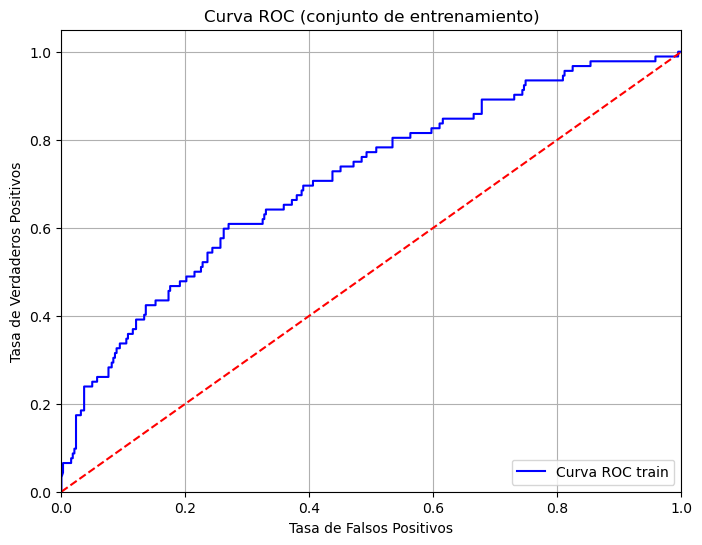

In [17]:
auc = roc_auc_score(y_train, y_proba_train)
print("AUC:", auc)

fpr, tpr, thresholds = roc_curve(y_train, y_proba_train, pos_label=1)
#graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC train', color='blue')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de entrenamiento)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


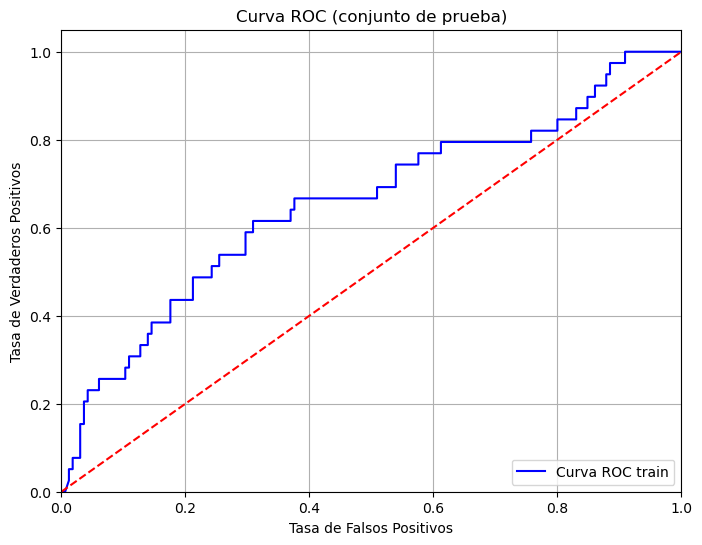

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test, pos_label=1)
#graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC train', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de prueba)')
plt.legend(loc='lower right')
plt.grid()
plt.show()



In [19]:
import dalex as dx

In [20]:
exp = dx.Explainer(model, X_final, y)
vi = exp.model_parts() 
vi.plot(max_vars=20)
#select the 10 most important variables from the explainer
imps = vi.result['variable'][-15:-1].tolist()
imps.append('id_registro')

Preparation of a new explainer is initiated

  -> data              : 678 rows 139 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 678 values
  -> model_class       : sklearn.svm._classes.SVC (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x13f415510> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0734, mean = 0.196, max = 0.579
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.579, mean = -0.00279, max = 0.917
  -> model_info        : package sklearn

A new explainer has been created!
